# Lab 8: Satellite Image Segmentation with U-Net

## Using PyTorch for Infrastructure Detection in Satellite Imagery

### Objective

This laboratory session focuses on implementing semantic segmentation using the U-Net architecture for analyzing satellite imagery. Students will work with a real-world dataset from ISRO (Indian Space Research Organisation) to identify and segment different infrastructure elements from satellite images. Through this hands-on experience, students will understand the practical aspects of image segmentation, experiment with encoder-decoder architectures, and learn how to handle real-world computer vision challenges.

### Learning Outcomes

After completing this lab, students will be able to:

- **Implement the U-Net architecture using PyTorch**
- **Process and prepare COCO format annotations for segmentation tasks**
- **Create custom dataset classes for handling satellite imagery**
- **Train a deep learning model for multi-class segmentation**
- **Evaluate segmentation results using industry-standard metrics**
- **Understand and implement skip connections in encoder-decoder architectures**

### Dataset Description

#### Satellite Infrastructure Dataset

- **Total Images:** 100
- **Image Resolution:** Variable (automatically resized during processing)
- **Format:** COCO JSON annotations
- **Train/Valid/Test Split:** 57/26/17 images

#### Class Distribution

- **Substations:** Electrical infrastructure
- **Towers:** Transmission towers and poles
- **Water Bodies:** Natural and artificial water features
- **Windmills:** Wind energy infrastructure


## Tasks

### Task 1: Data Preparation and Exploration



### Task 2: Dataset and DataLoader Creation




### Task 3: U-Net Architecture Implementation



### Task 4: Training Pipeline



### Task 5: Evaluation and Visualization



# What is Image Segmentation?
Image segmentation is a computer vision task that involves dividing an image into multiple segments or regions, where each pixel in the image is assigned a class label. Unlike classification that provides a single label for the entire image, segmentation creates a pixel-wise mask identifying different objects or regions.


**Types of Segmentation**

- Semantic Segmentation: Each pixel is assigned to a class (e.g., all towers are labeled the same)
- Instance Segmentation: Distinguishes between different instances of the same class
- Panoptic Segmentation: Combines semantic and instance segmentation

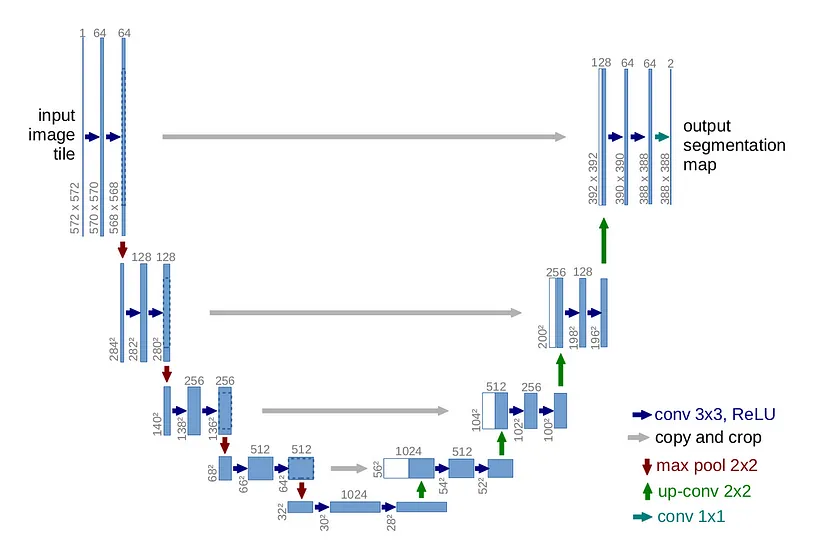
### What is U-Net?

U-Net is a convolutional neural network architecture designed specifically for biomedical image segmentation, first introduced by Ronneberger et al. in 2015. The architecture gets its name from its U-shaped structure:

#### Encoder Path (Contracting)

- **Captures context and features from the image**
- **Reduces spatial dimensions while increasing feature channels**
- **Uses consecutive convolutions and max pooling**

#### Decoder Path (Expanding)

- **Enables precise localization**
- **Increases spatial dimensions while decreasing feature channels**
- **Uses up-convolutions and concatenation with encoder features**

#### Skip Connections

- **Connect corresponding layers between encoder and decoder**
- **Help preserve fine-grained details**
- **Enable better gradient flow during training**

## Key Features of U-Net

### Architecture

U-Net has a U-shaped architecture with an encoder network followed by a decoder network. The encoder network reduces the height and width of the input image while increasing the number of channels. The decoder network then uses upsampling layers to convert the feature map back into an image of the same size as the input.

### Skip Connections

Skip connections are used between the encoder and decoder to help the decoder layers locate and refine features in the image.

### Training

U-Net can be trained with fewer training images than other networks, and can be adapted to new tasks based on a few annotated samples.


### Image Segmentation Types

#### Semantic Segmentation

- **Assigns each pixel to a class**
- **Doesn't differentiate between instances of the same class**

#### Instance Segmentation

- **Distinguishes between different instances of the same class**
- **Provides unique identification for each instance**


In [1]:
# Required packages
!pip install torch torchvision
!pip install albumentations
!pip install pycocotools
!pip install opencv-python
!pip install albumentations segmentation-models-pytorch



  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fdf62ade9fb89b88f55788d5e0fe8f92b652ce47b0e0f0fe6b7e508623ecdf76
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0bd053722f932ca06a02f8c436a48a1215405baa3138e73501bdbe9f6c49bbf5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

### Task 1: Data Preparation and Exploration

In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import segmentation_models_pytorch as smp

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Set the base path to your dataset in Google Drive
# Replace with your actual path
BASE_PATH = '/content/drive/MyDrive/Image_Sagment/Isro_Project.v3i.coco-segmentation'

# Define paths for train, validation, and test sets
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Path to annotation files
TRAIN_ANN = os.path.join(TRAIN_PATH, '_annotations.coco.json')
VALID_ANN = os.path.join(VALID_PATH, '_annotations.coco.json')
TEST_ANN = os.path.join(TEST_PATH, '_annotations.coco.json')

## Understanding COCO Format

The COCO (Common Objects in Context) format is a standard for object detection and segmentation annotations. Key components include:

### Images

Contains metadata about images, such as:
- **file_name:** Name of the image file
- **height:** Height of the image in pixels
- **width:** Width of the image in pixels

### Categories

Defines the classes in the dataset, including:
- **id:** Unique identifier for each class
- **name:** Name of the class

### Annotations

Contains detailed information about each annotated instance, including:
- **segmentation:** List of polygon points defining the mask
- **category_id:** Class ID for the instance
- **bbox:** Bounding box coordinates in the format [x, y, width, height]
- **area:** Area of the segmentation mask

## Data Preprocessing Steps

### Mask Generation

- **Convert COCO polygons to binary masks:** Transform the polygon annotations into binary masks where each pixel is either part of the object or not.
- **Create multi-channel masks for each class:** Generate separate mask channels for each class to facilitate multi-class segmentation.

### Image Normalization

- **Resize images to consistent dimensions:** Standardize all images to the same size to ensure uniformity during training.
- **Normalize pixel values to [0,1]:** Scale pixel intensities to a range between 0 and 1 for better convergence during training.
- **Apply standard normalization (mean/std):** Normalize images using the dataset's mean and standard deviation to improve model performance.

### Data Augmentation

- **Random horizontal/vertical flips:** Randomly flip images horizontally or vertically to increase dataset variability.
- **Random rotations:** Rotate images by random angles to make the model invariant to orientation changes.
- **Color jittering:** Randomly change the brightness, contrast, saturation, and hue of images to enhance color robustness.
- **Random cropping:** Extract random crops from images to allow the model to learn from different parts of the image and improve localization.



In [8]:
def explore_dataset(base_path, ann_file):
    """
    Explore and print information about the dataset

    Args:
        base_path: Path to image directory
        ann_file: Path to COCO annotation file
    """
    # Load COCO annotations
    coco = COCO(ann_file)

    # Get category information
    cats = coco.loadCats(coco.getCatIds())
    print("\nDataset Categories:")
    for cat in cats:
        print(f"- {cat['name']}: {len(coco.getAnnIds(catIds=cat['id']))} annotations")

    # Get image information
    imgs = coco.loadImgs(coco.getImgIds())
    print(f"\nTotal Images: {len(imgs)}")

    # Display sample image sizes
    print("\nSample Image Sizes:")
    for img in imgs[:3]:
        print(f"- {img['file_name']}: {img['width']}x{img['height']}")

    return coco

# Explore training dataset
print("Training Dataset Information:")
train_coco = explore_dataset(TRAIN_PATH, TRAIN_ANN)

Training Dataset Information:
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!

Dataset Categories:
- towers: 0 annotations
- substation: 29 annotations
- towers: 20 annotations
- water_body: 17 annotations
- windmills: 16 annotations

Total Images: 57

Sample Image Sizes:
- fd3d7807-2089-4bdd-88cf-188f54a578f7_jpg.rf.03c0a1fa11ff64e8757cc834959418e9.jpg: 128x128
- fd3a1d7a-ed13-4680-8a44-66a03cbcf058_jpg.rf.12605f0be94d552012c4ccb41b2f6ff7.jpg: 128x128
- J2522_jpg.rf.06e88bcd80d26dac43587a2dfb211390.jpg: 750x750



Visualizing random samples:


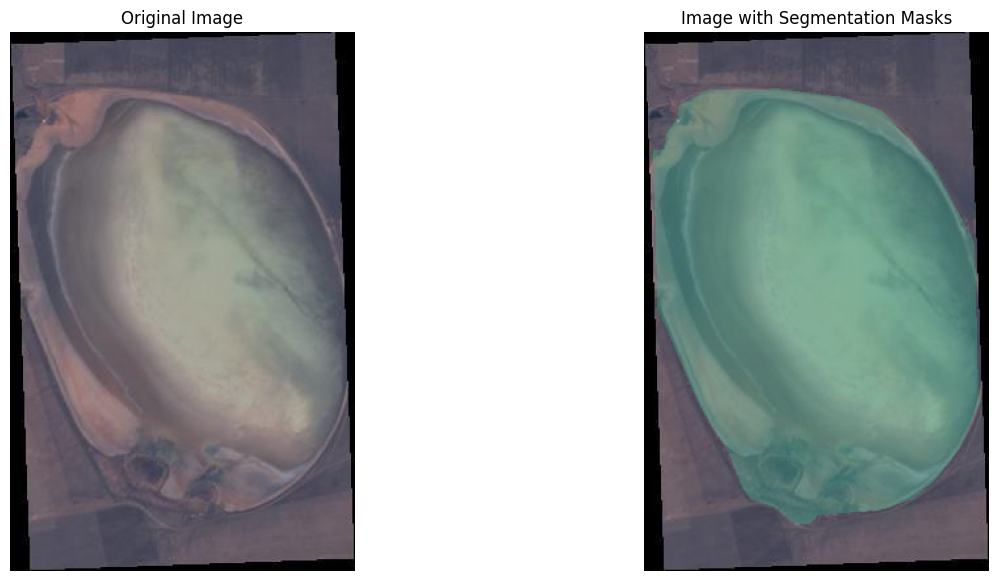

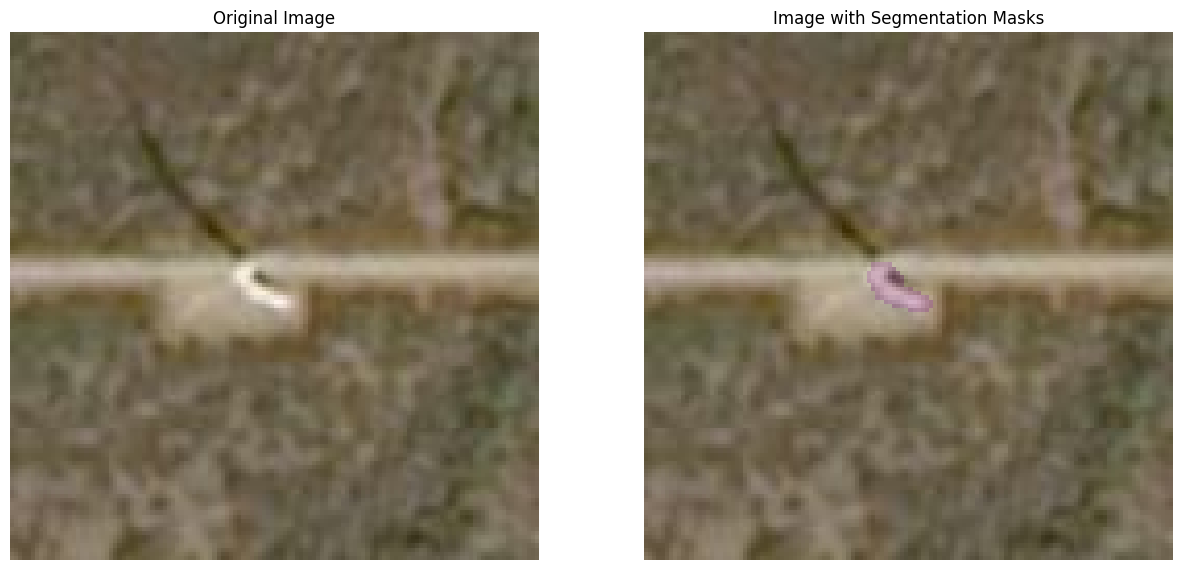

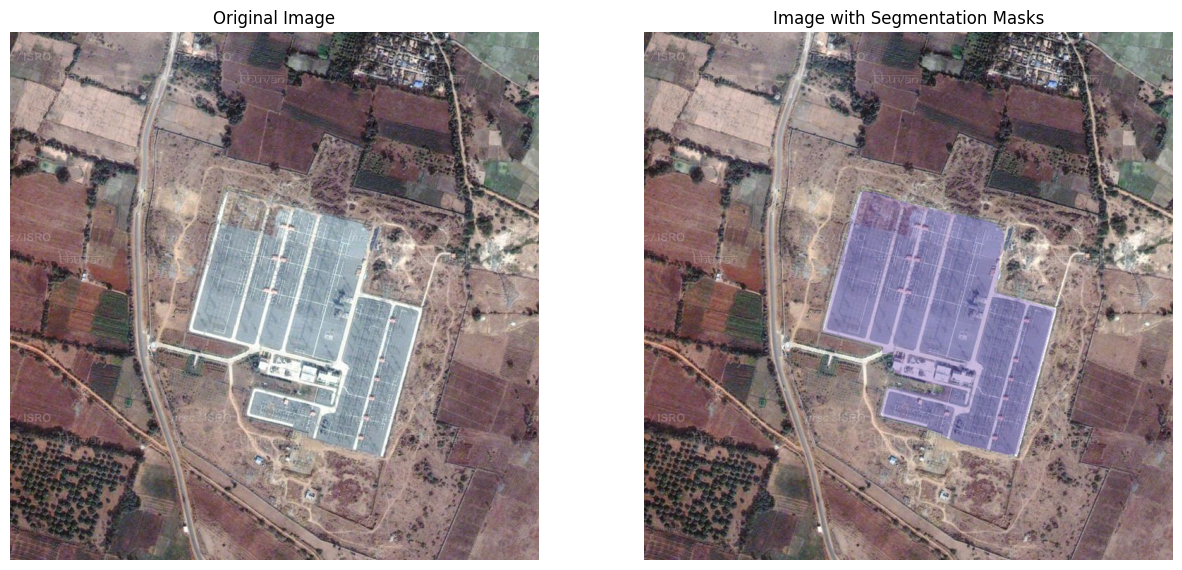

In [9]:
def visualize_sample(coco, img_id, save_path=None):
    """
    Visualize an image with its segmentation masks

    Args:
        coco: COCO object
        img_id: Image ID to visualize
        save_path: Optional path to save the visualization
    """
    # Load image info
    img_info = coco.loadImgs([img_id])[0]
    img_path = os.path.join(TRAIN_PATH, img_info['file_name'])

    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plot original image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Plot image with masks
    ax2.imshow(img)
    for ann in anns:
        mask = coco.annToMask(ann)
        color = np.random.random(3)
        masked_img = img.copy()
        for c in range(3):
            masked_img[:, :, c] = np.where(mask == 1,
                                         masked_img[:, :, c] * 0.5 + 255 * color[c] * 0.5,
                                         masked_img[:, :, c])
        ax2.imshow(masked_img, alpha=0.6)
    ax2.set_title('Image with Segmentation Masks')
    ax2.axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()

# Visualize a few random samples
print("\nVisualizing random samples:")
random_img_ids = np.random.choice(train_coco.getImgIds(), 3)
for img_id in random_img_ids:
    visualize_sample(train_coco, img_id)

In [10]:
# Define image size and transforms
IMG_SIZE = 128
# Define transforms for training
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.3),
    A.GaussNoise(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
# Define transforms for validation
val_transform = A.Compose([
A.Resize(IMG_SIZE, IMG_SIZE),
A.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225],
),
ToTensorV2()
])

In [11]:
class AugmentationPipeline:
    def __init__(self, img_size=256):  # Increased image size
        self.train_transform = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.3),
            A.GaussNoise(p=0.2),
            A.RandomBrightnessContrast(p=0.3),
            A.GridDistortion(p=0.2),
            A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        self.val_transform = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

class SatelliteSegmentationDataset(Dataset):
    def __init__(self, coco, root_dir, transform=None, return_meta=False):
        self.coco = coco
        self.root_dir = root_dir
        self.transform = transform
        self.return_meta = return_meta
        self.image_ids = coco.getImgIds()

        # Get list of categories
        self.cats = coco.loadCats(coco.getCatIds())
        self.num_classes = len(self.cats)
        self.cat_id_to_idx = {cat['id']: idx for idx, cat in enumerate(self.cats)}

        # Calculate class weights
        self.class_weights = self._calculate_class_weights()

    def _calculate_class_weights(self):
        class_counts = np.zeros(self.num_classes)
        total_pixels = 0

        for img_id in self.image_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)

            for ann in anns:
                cat_idx = self.cat_id_to_idx[ann['category_id']]
                mask = self.coco.annToMask(ann)
                class_counts[cat_idx] += mask.sum()
                total_pixels += mask.size

        class_weights = 1.0 / (class_counts + 1e-6)
        class_weights = class_weights / class_weights.sum()
        return torch.FloatTensor(class_weights)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]

        # Load image
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create mask
        mask = np.zeros((img_info['height'], img_info['width'], self.num_classes),
                       dtype=np.float32)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            cat_idx = self.cat_id_to_idx[ann['category_id']]
            mask[:, :, cat_idx] = np.maximum(mask[:, :, cat_idx],
                                           self.coco.annToMask(ann))

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)
            else:
                mask = mask.permute(2, 0, 1)

        if self.return_meta:
            return image, mask, img_info
        return image, mask

In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, 1),
            nn.BatchNorm2d(in_channels//8),
            nn.ReLU(),
            nn.Conv2d(in_channels//8, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.attention = AttentionBlock(out_channels)

    def forward(self, x):
        x = self.double_conv(x)
        x = self.attention(x)
        return x

class EnhancedUNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=5):
        super().__init__()

        # Use pretrained encoder
        self.encoder = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=input_channels,
            classes=num_classes,
        )

        # Add additional attention blocks
        self.attention1 = AttentionBlock(256)
        self.attention2 = AttentionBlock(128)
        self.attention3 = AttentionBlock(64)

        # Add deep supervision
        self.deep_sup1 = nn.Conv2d(256, num_classes, 1)
        self.deep_sup2 = nn.Conv2d(128, num_classes, 1)
        self.deep_sup3 = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        # Get encoder features
        features = self.encoder.encoder(x)

        # Apply attention
        features[-2] = self.attention1(features[-2])
        features[-3] = self.attention2(features[-3])
        features[-4] = self.attention3(features[-4])

        # Decoder
        decoder_output = self.encoder.decoder(*features)

        # Deep supervision outputs
        deep_outputs = [
            F.interpolate(self.deep_sup1(features[-2]), size=x.shape[2:], mode='bilinear'),
            F.interpolate(self.deep_sup2(features[-3]), size=x.shape[2:], mode='bilinear'),
            F.interpolate(self.deep_sup3(features[-4]), size=x.shape[2:], mode='bilinear')
        ]

        # Main output
        main_output = self.encoder.segmentation_head(decoder_output)

        if self.training:
            return main_output, deep_outputs
        return main_output

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        predictions = []
        for model in self.models:
            predictions.append(model(x))
        return torch.mean(torch.stack(predictions), dim=0)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, pred, target):
        ce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weights=[0.5, 0.3, 0.2]):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.focal = FocalLoss()
        self.weights = weights

    def forward(self, pred, target):
        if isinstance(pred, tuple):
            main_pred, deep_outputs = pred
            # Calculate loss for main output
            main_loss = (
                self.weights[0] * self.bce(main_pred, target) +
                self.weights[1] * self.dice(main_pred, target) +
                self.weights[2] * self.focal(main_pred, target)
            )
            # Calculate deep supervision loss
            deep_loss = 0
            for deep_out in deep_outputs:
                deep_loss += (
                    self.weights[0] * self.bce(deep_out, target) +
                    self.weights[1] * self.dice(deep_out, target) +
                    self.weights[2] * self.focal(deep_out, target)
                )
            return main_loss + 0.3 * deep_loss
        else:
            return (
                self.weights[0] * self.bce(pred, target) +
                self.weights[1] * self.dice(pred, target) +
                self.weights[2] * self.focal(pred, target)
            )

In [24]:
class SegmentationTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=50,
        early_stopping_patience=10
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs
        self.early_stopping_patience = early_stopping_patience

    def train_epoch(self):
        self.model.train()
        total_loss = 0

        for batch_idx, (images, masks) in enumerate(self.train_loader):
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}')

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, masks in self.val_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                total_loss += loss.item()

        return total_loss / len(self.val_loader)

    def train(self):
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.num_epochs):
            print(f'\nEpoch {epoch+1}/{self.num_epochs}')

            train_loss = self.train_epoch()
            val_loss = self.validate()

            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Model checkpointing
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), 'best_model.pth')
                patience_counter = 0
                print('Saved best model!')
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print('Early stopping triggered!')
                    break

# Initialize components
def initialize_training(train_path, val_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load COCO annotations
    train_coco = COCO(os.path.join(train_path, '_annotations.coco.json'))
    val_coco = COCO(os.path.join(val_path, '_annotations.coco.json'))

    # Setup augmentations
    augmentation = AugmentationPipeline(img_size=256)

    # Create datasets
    train_dataset = SatelliteSegmentationDataset(
        train_coco,
        train_path,
        transform=augmentation.train_transform
    )

    val_dataset = SatelliteSegmentationDataset(
        val_coco,
        val_path,
        transform=augmentation.val_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model
    model = EnhancedUNet(input_channels=3, num_classes=5).to(device)

    # Initialize loss and optimizer
    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )

    # Initialize scheduler
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )

    return model, train_loader, val_loader, criterion, optimizer, scheduler, device

In [15]:
def main():
    # Setup augmentations
    augmentation = AugmentationPipeline(img_size=256)

    # Define paths (update these)
    BASE_PATH = '/content/drive/MyDrive/Image_Sagment/Isro_Project.v3i.coco-segmentation'
    TRAIN_PATH = os.path.join(BASE_PATH, 'train')
    VALID_PATH = os.path.join(BASE_PATH, 'valid')

    # Load COCO annotations
    train_coco = COCO(os.path.join(TRAIN_PATH, '_annotations.coco.json'))
    val_coco = COCO(os.path.join(VALID_PATH, '_annotations.coco.json'))

    # Create datasets
    train_dataset = SatelliteSegmentationDataset(
        train_coco,
        TRAIN_PATH,
        transform=augmentation.train_transform
    )

    val_dataset = SatelliteSegmentationDataset(
        val_coco,
        VALID_PATH,
        transform=augmentation.val_transform
    )

    # Initialize training components
    model, train_loader, val_loader, criterion, optimizer, scheduler, device = \
        initialize_training(train_dataset, val_dataset, batch_size=8)

    # Create trainer
    trainer = SegmentationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=50,
        early_stopping_patience=10
    )

    # Start training
    trainer.train()

In [32]:
class SegmentationPredictor:
    def __init__(self, model_path, device):
        self.device = device
        self.model = EnhancedUNet(input_channels=3, num_classes=5).to(device)
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

        self.transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def predict_image(self, image_path):
        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = self.transform(image=image)
        input_tensor = transformed['image'].unsqueeze(0).to(self.device)

        # Make prediction
        with torch.no_grad():
            output = self.model(input_tensor)
            prediction = torch.sigmoid(output).squeeze().cpu().numpy()

        return prediction

    def visualize_prediction(self, image_path, save_path=None):
        # Load original image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get prediction
        prediction = self.predict_image(image_path)

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Plot original image
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Plot prediction
        combined_mask = prediction.sum(axis=0)
        ax2.imshow(combined_mask, cmap='gray')
        ax2.set_title('Predicted Segmentation')
        ax2.axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

def evaluate_model(model, val_loader, device):
    """
    Evaluate model performance using multiple metrics
    """
    model.eval()
    metrics = {
        'iou': [],
        'dice': [],
        'precision': [],
        'recall': []
    }

    print("Starting evaluation...")
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            try:
                images = images.to(device)
                masks = masks.to(device)

                # Get predictions
                outputs = model(images)
                if isinstance(outputs, tuple):  # Handle deep supervision output
                    outputs = outputs[0]

                predictions = torch.sigmoid(outputs)
                predictions = (predictions > 0.5).float()

                # Calculate metrics for each image in batch
                for i in range(images.size(0)):
                    pred = predictions[i]
                    mask = masks[i]

                    # Calculate Intersection and Union
                    intersection = torch.sum(pred * mask)
                    union = torch.sum(pred) + torch.sum(mask) - intersection

                    # Calculate IoU
                    iou = (intersection + 1e-6) / (union + 1e-6)

                    # Calculate Dice
                    dice = (2 * intersection + 1e-6) / (
                        torch.sum(pred) + torch.sum(mask) + 1e-6
                    )

                    # Calculate True Positives, False Positives, False Negatives
                    true_positives = torch.sum(pred * mask)
                    pred_positives = torch.sum(pred)
                    actual_positives = torch.sum(mask)

                    # Calculate Precision and Recall
                    precision = (true_positives + 1e-6) / (pred_positives + 1e-6)
                    recall = (true_positives + 1e-6) / (actual_positives + 1e-6)

                    # Store metrics
                    metrics['iou'].append(iou.item())
                    metrics['dice'].append(dice.item())
                    metrics['precision'].append(precision.item())
                    metrics['recall'].append(recall.item())

                if batch_idx % 5 == 0:
                    print(f"Processed batch {batch_idx}/{len(val_loader)}")

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                continue

    # Calculate mean metrics
    final_metrics = {}
    for key in metrics:
        if metrics[key]:
            final_metrics[key] = sum(metrics[key]) / len(metrics[key])
        else:
            final_metrics[key] = 0.0

    # Calculate F1 from mean precision and recall
    if final_metrics['precision'] + final_metrics['recall'] > 0:
        final_metrics['f1'] = 2 * (final_metrics['precision'] * final_metrics['recall']) / (
            final_metrics['precision'] + final_metrics['recall']
        )
    else:
        final_metrics['f1'] = 0.0

    return final_metrics


In [17]:
main()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 314MB/s]



Epoch 1/50
Batch 0/8, Loss: 1.4569
Training Loss: 1.4331
Validation Loss: 0.8938
Saved best model!

Epoch 2/50
Batch 0/8, Loss: 1.4049
Training Loss: 1.3761
Validation Loss: 1.1226

Epoch 3/50
Batch 0/8, Loss: 1.3249
Training Loss: 1.3367
Validation Loss: 0.9406

Epoch 4/50
Batch 0/8, Loss: 1.2996
Training Loss: 1.3033
Validation Loss: 0.7830
Saved best model!

Epoch 5/50
Batch 0/8, Loss: 1.2957
Training Loss: 1.2795
Validation Loss: 0.7016
Saved best model!

Epoch 6/50
Batch 0/8, Loss: 1.2484
Training Loss: 1.2545
Validation Loss: 0.6801
Saved best model!

Epoch 7/50
Batch 0/8, Loss: 1.2229
Training Loss: 1.2417
Validation Loss: 0.6462
Saved best model!

Epoch 8/50
Batch 0/8, Loss: 1.2171
Training Loss: 1.2249
Validation Loss: 0.7134

Epoch 9/50
Batch 0/8, Loss: 1.1930
Training Loss: 1.2043
Validation Loss: 0.6353
Saved best model!

Epoch 10/50
Batch 0/8, Loss: 1.1880
Training Loss: 1.1913
Validation Loss: 0.6199
Saved best model!

Epoch 11/50
Batch 0/8, Loss: 1.1681
Training Loss: 1

In [20]:
# Load and use the trained model
predictor = SegmentationPredictor('best_model.pth', device='cuda')

# Make predictions on new images
image_path = '/content/drive/MyDrive/Image_Sagment/Isro_Project.v3i.coco-segmentation/test/gettyimages-1169057606-170667a_jpg.rf.541c53b5e164b15021cc5f9f67631137.jpg'
predictor.visualize_prediction(image_path, save_path='prediction.png')

<ipython-input-16-4aa760b8bc66>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


In [33]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    """
    Visualize model predictions
    """
    model.eval()
    images, masks = next(iter(val_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()

    # Move tensors to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    # Visualize results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        img = np.clip(img, 0, 255).astype(np.uint8)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground truth
        mask = masks[i].sum(dim=0).numpy()
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Prediction
        pred = predictions[i].sum(dim=0).numpy()
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [34]:
def load_and_evaluate(model_path, train_path, valid_path):
    print("Initializing model and data loaders...")
    model, train_loader, val_loader, criterion, optimizer, scheduler, device = initialize_training(train_path, valid_path)

    print("Loading model weights...")
    model.load_state_dict(torch.load(model_path, weights_only=True))

    print("Evaluating model...")
    metrics = evaluate_model(model, val_loader, device)

    print("\nModel Performance Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name.upper()}: {value:.4f}")

    print("\nGenerating visualization...")
    visualize_predictions(model, val_loader, device)

    return metrics

In [35]:
TRAIN_PATH = '/content/drive/MyDrive/Image_Sagment/Isro_Project.v3i.coco-segmentation/train'
VALID_PATH = '/content/drive/MyDrive/Image_Sagment/Isro_Project.v3i.coco-segmentation/valid'
MODEL_PATH = '/content/best_model.pth'

metrics = load_and_evaluate(MODEL_PATH, TRAIN_PATH, VALID_PATH)

Initializing model and data loaders...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading model weights...
Evaluating model...
Starting evaluation...
Processed batch 0/4

Model Performance Metrics:
IOU: 0.2918
DICE: 0.3806
PRECISION: 0.4081
RECALL: 0.4302
F1: 0.4188

Generating visualization...


# Key Observations

## Model Performance

| **Metric**   | **Score** | **Percentage** |
|--------------|-----------|-----------------|
| IoU Score    | 0.2918    | 29.18%          |
| Dice Score   | 0.3806    | 38.06%          |
| Precision    | 0.4081    | 40.81%          |
| Recall       | 0.4302    | 43.02%          |
| F1 Score     | 0.4188    | 41.88%          |

## Visual Analysis

- **General Detection**: The model demonstrates the ability to detect general structures in satellite images.
- **Substations and Solar Farms** (First and Third Images):
  - **Observation**: The model detects the presence of these structures.
  - **Issue**: Tends to generate more circular predictions than the actual rectangular shapes.
- **Water Bodies** (Second Image):
  - **Observation**: The model performs better with more accurate shape predictions.
- **Overall**: There is room for improvement in boundary precision and shape accuracy.

## Areas for Improvement

- **Shape Preservation**: Enhance the model's ability to maintain accurate shapes of detected objects.
- **Boundary Detection**: Improve the precision of boundary detection to better match actual object edges.
- **Prediction Bias**: Address the model's tendency to favor circular predictions for structures that are inherently rectangular.

